Generate data and save it so later can be analyzed

In [2]:
import MDAnalysis as md
import matplotlib.pyplot as plt
import numpy as np
import cyltransf as ct

file_dir = "data100ns-2008"
output_dir = "output"

u_mean = md.Universe(file_dir + "/md_1.tpr", output_dir + "/md_1_mean.xtc")

`u_mean` already contains the whole information of the mean positions, then one can do manipulation with it more quickly. The only thing is that the routine of centering has to be changed inside. Then we can get the whole fragments list and use it for the next steps.

In [3]:
chains = u_mean.select_atoms("protein").fragments

In [13]:
mol = 0
molecule = chains[3*mol:3*mol + 3]
molecule_coords = (molecule[0] + molecule[1]+ molecule[2]).positions

molecule_mean_filt = ct.remove_ends(0.5, molecule_coords) / 10

# Cylindrical Coordinates
rad_mol, phi_mol, z_mol = ct.cyl_proj(molecule_mean_filt)

#rad_mol, phi_mol, z_mol = ct.cyl_proj(molecule_coords)

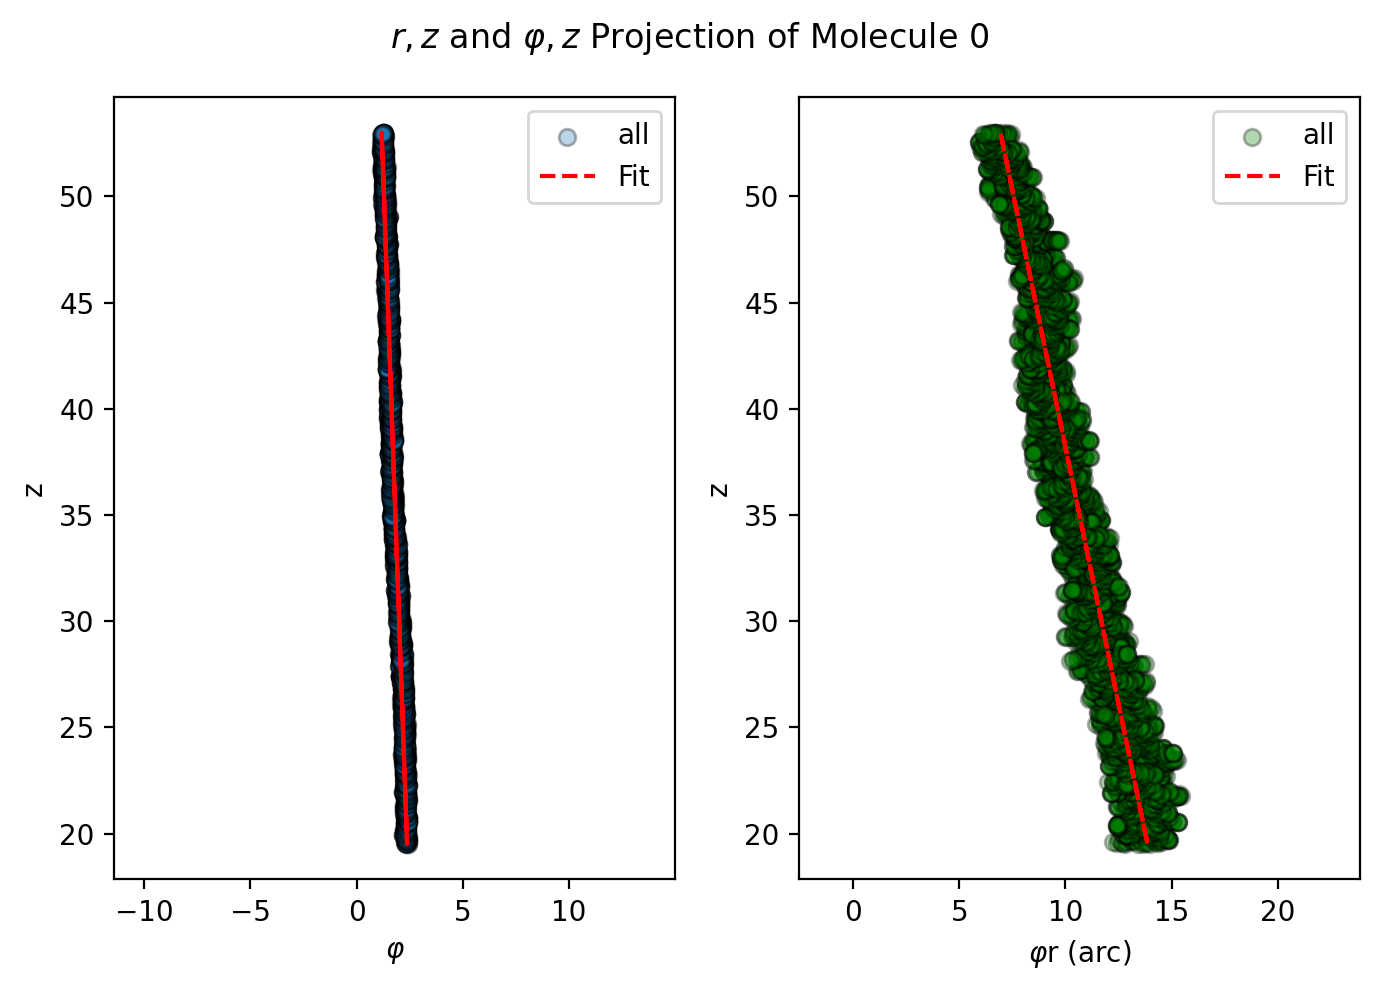

In [14]:
atoms_label = 'all'

arc_mol = rad_mol*phi_mol

fig, ax = plt.subplots(1, 2, figsize=(7,5), dpi=200)

ax[0].scatter(phi_mol, z_mol, alpha=0.3, edgecolor='k', label=atoms_label)
mp, bp, r2filt = ct.linfitandr2(phi_mol, z_mol)
# b, m = np.polynomial.polynomial.polyfit(phi_mol, z_mol, 1)
# fit = np.polynomial.polynomial.Polynomial((b, m))  
b, m = np.polynomial.polynomial.polyfit(z_mol, phi_mol, 1)
fit = np.polynomial.polynomial.Polynomial((b, m))  
ax[0].plot(fit(z_mol), z_mol, linestyle='dashed', color='r', label='Fit')

ax[0].axis('equal')
ax[0].set_xlabel(r'$\varphi$')
ax[0].set_ylabel(r'z')
ax[0].legend()

ax[1].scatter(arc_mol, z_mol, color='g', alpha=0.3, edgecolor='k', label=atoms_label)
b, m = np.polynomial.polynomial.polyfit(z_mol, arc_mol, 1)
fit = np.polynomial.polynomial.Polynomial((b, m))  
ax[1].plot(fit(z_mol), z_mol, linestyle='dashed', color='r', label='Fit')

ax[1].axis('equal')
ax[1].set_xlabel(r'$\varphi$r (arc)')
ax[1].set_ylabel(r'z')
ax[1].legend()

plt.suptitle(rf'$r, z$ and $\varphi, z$ Projection of Molecule {mol}')
plt.tight_layout()
plt.show()

In [10]:
tot_mol = int((len(chains))/3)
tau = np.zeros(tot_mol)
r2s = np.zeros(tot_mol)
mean_rad = np.zeros(tot_mol)
std_rad = np.zeros(tot_mol)
length = np.zeros(tot_mol)


for mol in range(tot_mol):
    molecule = chains[3*mol:3*mol + 3]
    molecule_coords = (molecule[0] + molecule[1]+ molecule[2]).positions

    # Length of the Molecule
    length[mol] = molecule_coords[:,2].max() - molecule_coords[:,2].min() / 10

    # Apply Filter
    molecule_mean_filt = ct.remove_ends(0.5, molecule_coords) / 10

    # Cylindrical Coordinates
    rad, phi, z = ct.cyl_proj(molecule_mean_filt)
    arc = rad*phi

    # Fit and R2
    tau[mol], _, r2s[mol] = ct.linfitandr2(z, arc)
    # _, tau[mol] = np.polynomial.polynomial.polyfit(z, arc, 1)

    # Radius Data
    mean_rad[mol] = np.mean(rad)
    std_rad[mol] = np.std(rad)

/var/folders/mh/rthhjqxd0q17zgrqn8510w6h0000gn/T/ipykernel_7368/638919399.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  tau[mol], _, r2s[mol] = ct.linfitandr2(z, arc)


In [11]:
# filter R^2
filt_r2 = 0.80

# Psi - Deg
psi = np.rad2deg(np.atan(abs(tau)))

# Filter data
maskr2 = (r2s >= filt_r2)
tau_filt = tau[maskr2]
psi_filt = psi[maskr2]
mean_rad_filt = mean_rad[maskr2]
std_rad_filt = std_rad[maskr2]
length_filt = length[maskr2]

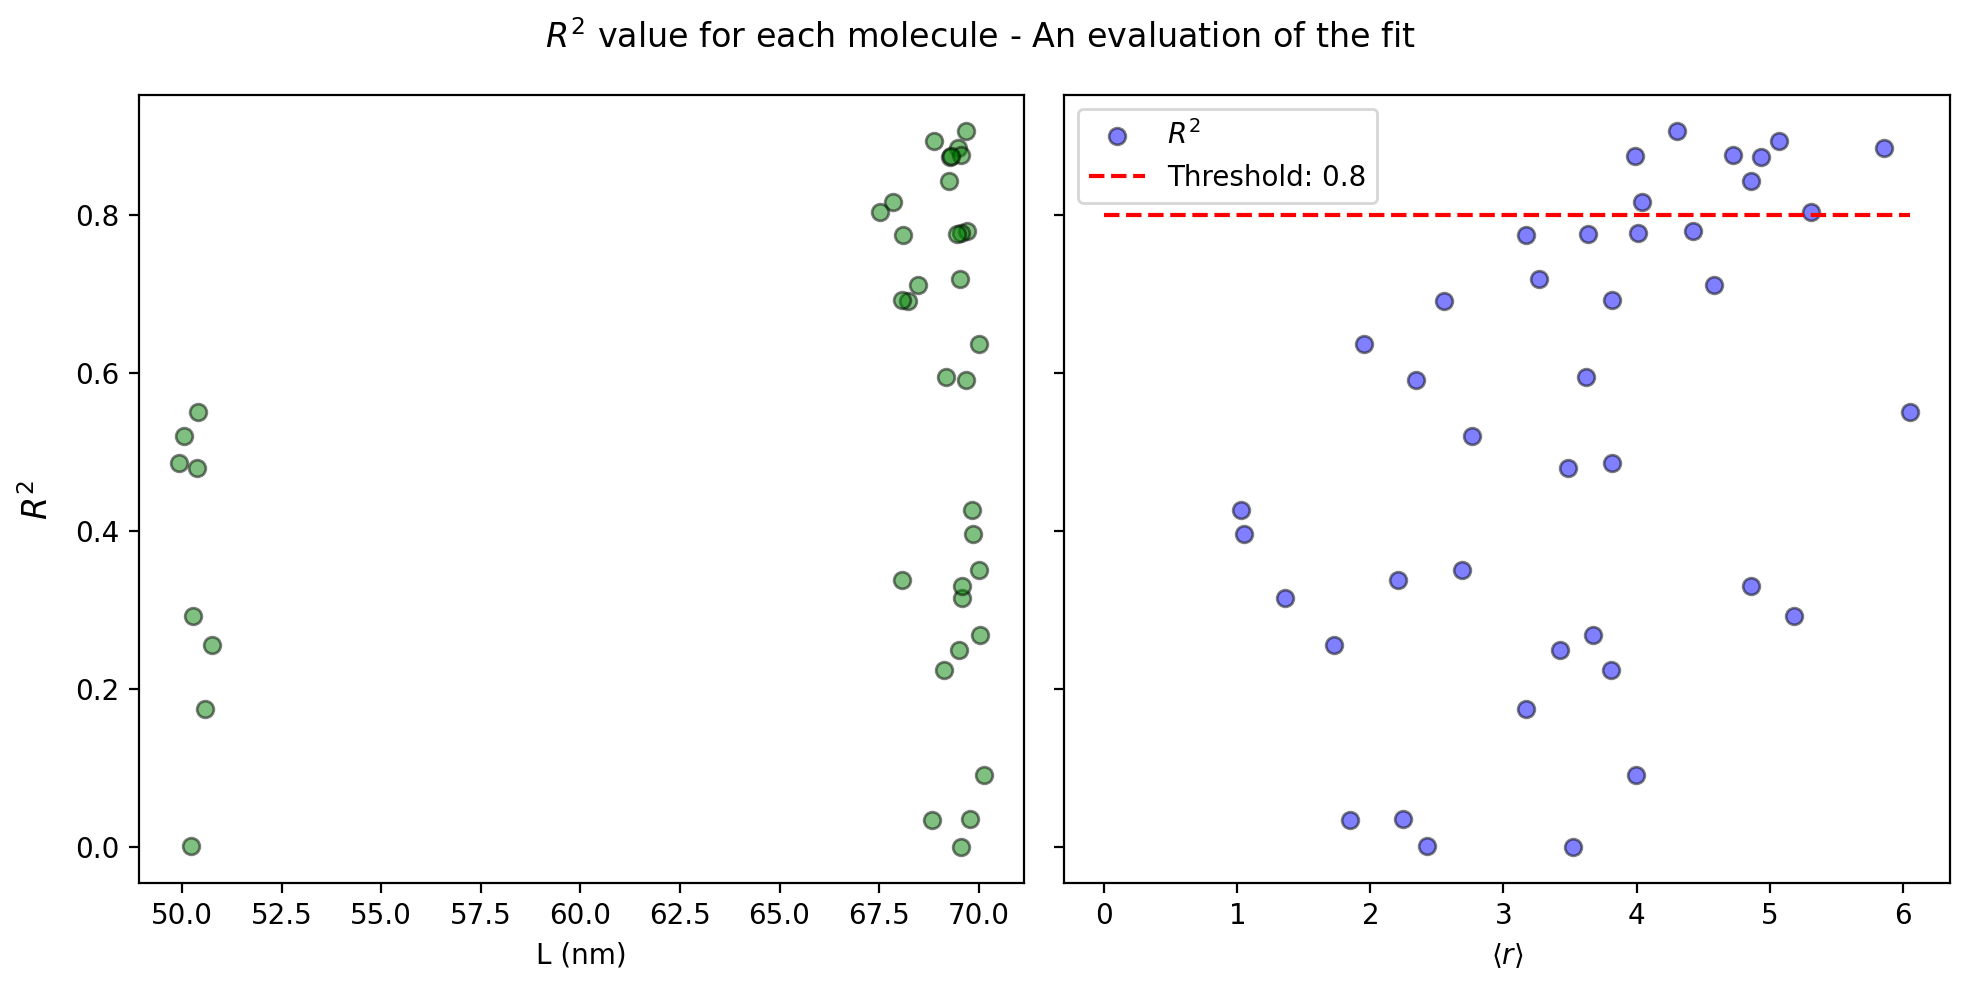

In [12]:
# Visualization of the Rsquared
fig, axs = plt.subplots(1, 2, figsize=(10, 5), dpi=200, sharey=True)
axs[0].scatter(length/10, r2s, color='g', edgecolor='k', alpha=0.5)
axs[0].set_xlabel(r'L (nm)')

axs[1].scatter(mean_rad, r2s, color='b', edgecolor='k', alpha=0.5, label=r'$R^2$')
axs[1].hlines(filt_r2, 0, max(mean_rad), color='r', linestyle='dashed', label=f'Threshold: {filt_r2}')
axs[1].set_xlabel(r'$\langle r \rangle$')
axs[1].legend()

fig.supylabel(r'$R^2$')
fig.suptitle(r"$R^2$ value for each molecule - An evaluation of the fit")

plt.tight_layout()
plt.show()

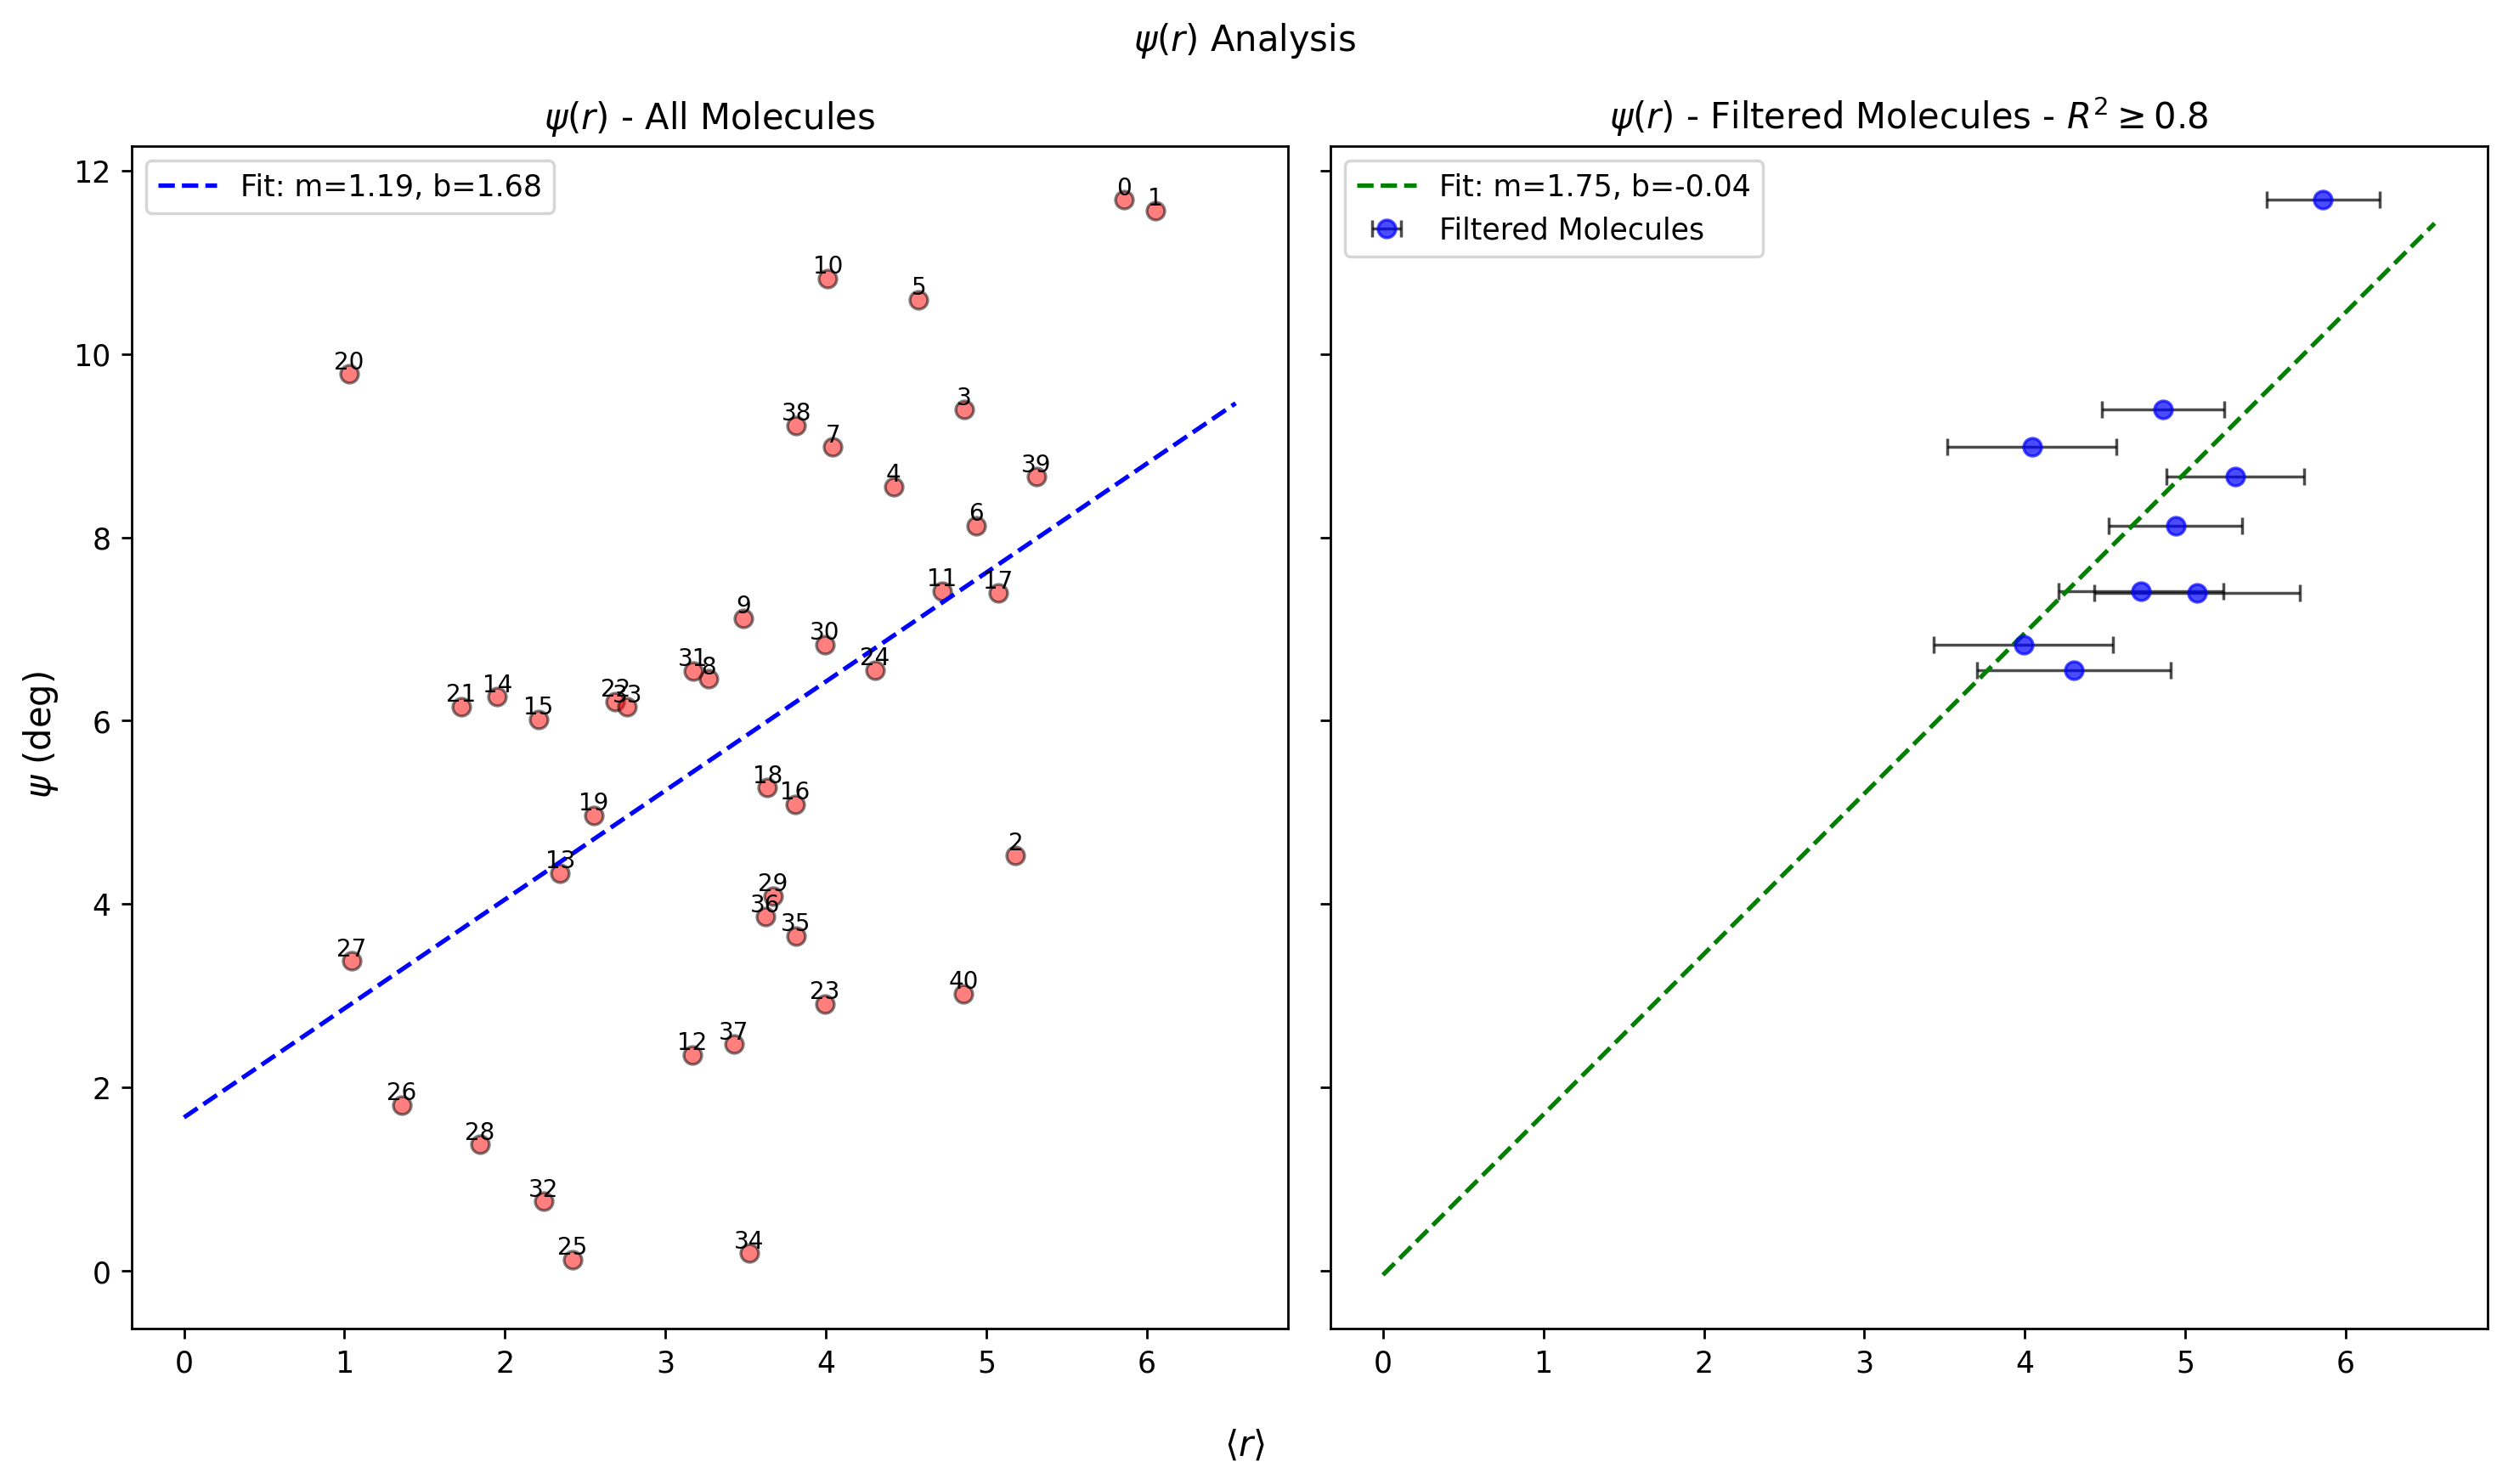

In [9]:
eval_fit = np.linspace(0, max(mean_rad) + 0.5, 1000)

# Plot
fig, ax = plt.subplots(1,2, figsize=(12,7),dpi=250, sharex=1, sharey=1)
# plt.plot(mean_rad, tau, color='k', linestyle='dashed')
ax[0].scatter(mean_rad, psi, color='r', edgecolor='k', alpha=0.5)
b_psi, m_psi = np.polynomial.polynomial.polyfit(mean_rad, psi, 1)
fit = np.polynomial.polynomial.Polynomial((b_psi, m_psi))  
ax[0].plot(eval_fit, fit(eval_fit), linestyle='dashed', color='b', label=f'Fit: m={m_psi:.2f}, b={b_psi:.2f}')

# Label Molecules
for i, (x, y) in enumerate(zip(mean_rad, psi)):
    ax[0].text(x, y, str(i), fontsize=8, ha='center', va='bottom')

ax[0].set_title(r"$\psi(r)$ - All Molecules")
ax[0].legend()

# --- Filtered ---
ax[1].errorbar(mean_rad_filt, psi_filt, xerr=std_rad_filt, fmt='o', color='blue', alpha=0.7, ecolor='k', elinewidth=1, capsize=3, label='Filtered Molecules')
b_psif, m_psif = np.polynomial.polynomial.polyfit(mean_rad_filt, psi_filt, 1)
fit = np.polynomial.polynomial.Polynomial((b_psif, m_psif))  
ax[1].plot(eval_fit, fit(eval_fit), linestyle='dashed', color='g', label=f'Fit: m={m_psif:.2f}, b={b_psif:.2f}')
ax[1].set_title(rf"$\psi(r)$ - Filtered Molecules - $R^2 \geq${filt_r2}")
ax[1].legend()

fig.supxlabel(r'$\langle r \rangle$')
fig.supylabel(r'$\psi$ (deg)')

plt.suptitle(r"$\psi(r)$ Analysis")
plt.tight_layout()
plt.show()